In [1]:
import os; os.chdir('/Users/sqian/MKTSRV')
import pandas as pd; pd.set_option('mode.chained_assignment',None) 
import xlrd
import re
import numpy as np
from xlsxwriter.utility import xl_rowcol_to_cell
from scipy import stats
from matplotlib import pyplot as plt
from math import log10, floor

from datetime import date
import datetime
import matplotlib.cbook as cbook

from src.data_models.smartshelper import metrics, fixNum, unSMART, cparty, littleQA, totalUP
from src.data_models.SmartsDataModel import SmartsDataModel
from src.data_models.SmartsCsvDataModel import SmartsCsvDataModel
from src.utility.DataModelUtility import execute_query_data_frame

symbol_list = ['BTCUSD', 'ETHBTC', 'ETHUSD', 'ZECBTC', 'ZECETH', 'ZECUSD', 'LTCBTC', 'LTCETH', 'LTCUSD', 'ZECLTC', 'BCHBTC', 'BCHETH', 'BCHUSD', 'LTCBCH', 'ZECBCH']

/Users/sqian/.pyenv/versions/3.7.0/envs/env_370/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


#### Step 1: Read smarts csv data from datalab

In [2]:
eval_date = datetime.date(2019, 2, 1)
begin_date = datetime.date(2018, 12, 31)
instruments = 'BTCUSD'

data_model = SmartsCsvDataModel(download_data=True).evaluate(instrument=instruments, evaluation_date=eval_date, begin_date=begin_date, use_db=False)

INFO:root:Constructing Singleton
INFO:root:Using global configuration /Users/sqian/msv.yaml.
INFO:root:Completed loading configuration.


download_smarts_data 0:00:00.015139
read_csv_to_dk_dataframe 0:00:00.939280
pre_cleaning 0:03:36.876628


In [3]:
inputdata = data_model['BTCUSD'].loc[(data_model['BTCUSD']['date_time'].dt.year == 2019) & (data_model['BTCUSD']['order_type'] != 'market')]
inputdata['Date'] = inputdata['date_time'].dt.date
# inputdata

In [28]:
def rollupMetrics(accountnum):
    inputdata_acc = inputdata.loc[inputdata['account_id'] == accountnum]
    
    data0_place = inputdata_acc.loc[(inputdata_acc['event_type'] == 'Place'),['order_id','date_time','original_quantity']]
    data0_cancel = inputdata_acc.loc[inputdata_acc['event_type'] == 'Cancel',['order_id','date_time']]
    data0_fill = inputdata_acc.loc[inputdata_acc['event_type'] == 'Fill',['order_id','date_time']].groupby(['order_id']).min()
    
    data1 = pd.concat([data0_place.set_index(['order_id']),data0_cancel.set_index(['order_id']),data0_fill],axis=1)
    data1.columns = ['place','quantity','cancel','fill']
    data1['canceltime'] = (data1['cancel'] - data1['place']).dt.total_seconds()/60
    data1['filltime'] = (data1['fill'] - data1['place']).dt.total_seconds()/60
    
    data2 = data1.loc[~data1['place'].isna()]
#     print(data2.head(20))
    
    print('Account Number: ',accountnum)
    print('Cancels within 1 second', str(round(stats.percentileofscore(data2['canceltime'], 1/60),1))+'%')
    print('Cancels within 1 minute', str(round(stats.percentileofscore(data2['canceltime'], 1),1))+'%')
    print('Cancels within 5 minute', str(round(stats.percentileofscore(data2['canceltime'], 5),1))+'%')
    
    print('Fills within 1 second', str(round(stats.percentileofscore(data2['filltime'].dropna(), 1/60),1))+'%')
    print('Fills within 1 minute', str(round(stats.percentileofscore(data2['filltime'].dropna(), 1),1))+'%')
    print('Fills within 5 minute', str(round(stats.percentileofscore(data2['filltime'].dropna(), 5),1))+'%')
    print('Fills within 10 minute', str(round(stats.percentileofscore(data2['filltime'].dropna(), 10),1))+'%')  
    print('maxtime:', data2['filltime'].max())
    
    print('Fill rate = ',round((1-data2['cancel'].count()/data2['place'].count())*100,1).astype(str) +'%',sep='')
    print('The following histogram is clipped at {}, the 99.9th percentile'.format(data2['quantity'].quantile(0.999)))
    data2['quantity'].clip(0,10).hist(bins=50); plt.show()

In [17]:
# data2

Account Number:  22440
Cancels within 1 second 57.3%
Cancels within 1 minute 90.6%
Cancels within 5 minute 97.8%
Fills within 1 second 45.7%
Fills within 1 minute 86.8%
Fills within 5 minute 98.3%
Fills within 10 minute 99.7%
maxtime: 15.004016666666669
Fill rate = 1.5%
The following histogram is clipped at 12.88581558, the 99.9th percentile


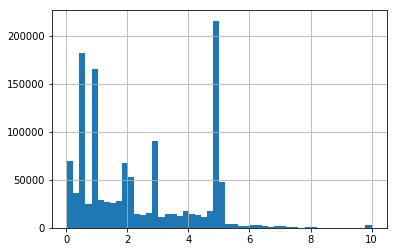

Account Number:  202474
Cancels within 1 second 4.9%
Cancels within 1 minute 35.8%
Cancels within 5 minute 49.8%
Fills within 1 second 29.7%
Fills within 1 minute 77.2%
Fills within 5 minute 86.7%
Fills within 10 minute 90.8%
maxtime: 87.09243333333333
Fill rate = 1.5%
The following histogram is clipped at 40.0, the 99.9th percentile


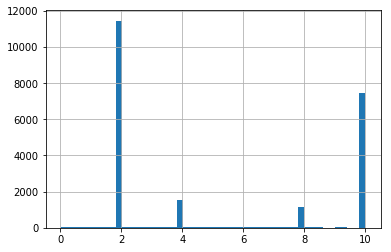

Account Number:  772544
Cancels within 1 second 2.5%
Cancels within 1 minute 2.5%
Cancels within 5 minute 2.5%
Fills within 1 second 100.0%
Fills within 1 minute 100.0%
Fills within 5 minute 100.0%
Fills within 10 minute 100.0%
maxtime: 1.6666666666666667e-05
Fill rate = 97.5%
The following histogram is clipped at 19.51703290000004, the 99.9th percentile


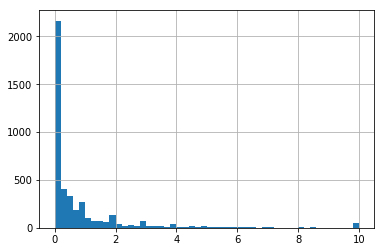

Account Number:  3032
Cancels within 1 second 74.2%
Cancels within 1 minute 94.4%
Cancels within 5 minute 98.7%
Fills within 1 second 30.3%
Fills within 1 minute 78.1%
Fills within 5 minute 89.1%
Fills within 10 minute 99.8%
maxtime: 82.89363333333334
Fill rate = 0.4%
The following histogram is clipped at 20.0, the 99.9th percentile


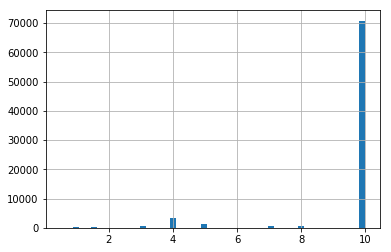

Account Number:  355845
Cancels within 1 second 50.4%
Cancels within 1 minute 77.7%
Cancels within 5 minute 91.8%
Fills within 1 second 49.5%
Fills within 1 minute 93.4%
Fills within 5 minute 99.7%
Fills within 10 minute 99.8%
maxtime: 42.59413333333334
Fill rate = 0.8%
The following histogram is clipped at 27.303908000000057, the 99.9th percentile


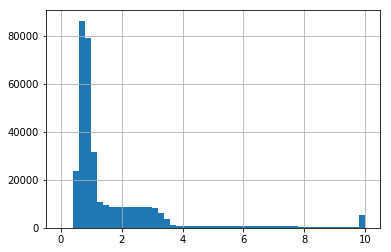

In [29]:
rollupMetrics(22440)
rollupMetrics(202474)
rollupMetrics(772544)
rollupMetrics(3032)
rollupMetrics(355845)

In [6]:
# delta1 = np.diff(price_data.adj_close) / price_data.adj_close[:-1]
# Marker size in units of points^2
# volume = (15 * price_data.volume[:-2] / price_data.volume[0])**2
# close = 0.003 * price_data.close[:-2] / 0.003 * price_data.open[:-2]

# volume = noninitialtuple['quantity']

# fig, ax = plt.subplots()
# ax.scatter(noninitialtuple['place'].values, noninitialtuple['canceltime'].clip(0,3000).values, s=volume, alpha=0.5)

# ax.set_xlabel(r'$\Delta_i$', fontsize=15)
# ax.set_ylabel(r'$\Delta_{i+1}$', fontsize=15)
# ax.set_title('Volume and percent change')

# ax.grid(True)
# fig.tight_layout()

# plt.show()

In [7]:
kens = pd.read_pickle('/Users/sqian/Downloads/202474_split_matrix.pkl')
kens.head()

,instrument,liquidity_indicator,side,place_cancel_time_diff,timediff_counts
0,BCHBTC,maker,buy,26.623,27
1,BCHBTC,maker,buy,26.624,27
2,BCHBTC,maker,buy,26.625,18
3,BCHBTC,maker,buy,26.622,9
4,BCHBTC,maker,buy,7.853,4
